<a href="https://colab.research.google.com/github/mgoncerz/SeparationPowerTool/blob/master/automatedTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Test settings:

In [0]:
import math

data_file = "data.csv"
csv_delimiter = ','

pearson_coeff_thresholds = {0.5, 0.6, 0.7}
cutoff_values = {5, 10, 15, 20}

columns_to_skip = {'', 'seed_p', 'seed_pt', 'has_MCParticle', 'is_downstream_reconstructible', 'has_MCParticle_not_electron', 'is_downstream_reconstructible_not_electron', 'is_true_seed', 'seed_mva_value'}
columns_to_add = {'seed_p_log', 'seed_pt_log', 'seed_r', 'seed_angle', 'seed_pseudorapidity'}

#use datarow['variable name']
def modify_variables(datarow):

  datarow['seed_p_log'] = math.log(float(datarow['seed_p']))
  datarow['seed_pt_log'] = math.log(float(datarow['seed_pt']))  

  datarow['seed_r'] = math.sqrt(float(datarow['seed_x']) * float(datarow['seed_x']) + float(datarow['seed_y']) * float(datarow['seed_y']))
  datarow['seed_angle'] = math.atan(float(datarow['seed_y']) / float(datarow['seed_x']))
  datarow['seed_pseudorapidity'] = math.atanh(float(datarow['seed_pt']) / float(datarow['seed_p']))

def general_selection(datarow):

  if datarow['has_MCParticle'] == 'True' and datarow['has_MCParticle_not_electron'] == 'True':
    return True
  else:
    return False

def signal_definition(datarow):
  
  if datarow['is_downstream_reconstructible'] == 'True':
    return True
  else:
    return False

Load data:

In [2]:
from csv import DictReader
import numpy

with open(data_file, "r") as datafile:

  datastream = DictReader(datafile)

  variable_names = [name for name in set(datastream.fieldnames).union(columns_to_add) if name not in columns_to_skip]
  signal_data = {name : [] for name in variable_names}
  background_data = {name : [] for name in variable_names}
  print(variable_names)

  #read from file and split into signal and background
  for datarow in datastream:

    modify_variables(datarow)

    if general_selection(datarow):

      if signal_definition(datarow):
        for variable in variable_names:
          signal_data[variable].append(float(datarow[variable]))

      else:
        for variable in variable_names:
          background_data[variable].append(float(datarow[variable]))

  #convert to numpy arrays and normalize
  for variable in variable_names:
    signal_data[variable] = numpy.array(signal_data[variable], dtype=float)
    background_data[variable] = numpy.array(background_data[variable], dtype=float)

    signal_data[variable] = (signal_data[variable] - signal_data[variable].mean()) / signal_data[variable].std()
    background_data[variable] = (background_data[variable] - background_data[variable].mean()) / background_data[variable].std()

['seed_nLayers', 'seed_angle', 'seed_r', 'seed_x', 'seed_nbIT', 'seed_nLHCbIDs', 'seed_tx', 'seed_chi2PerDoF', 'seed_y', 'seed_pt_log', 'seed_pseudorapidity', 'seed_p_log', 'seed_ty']


Plot normalized data:

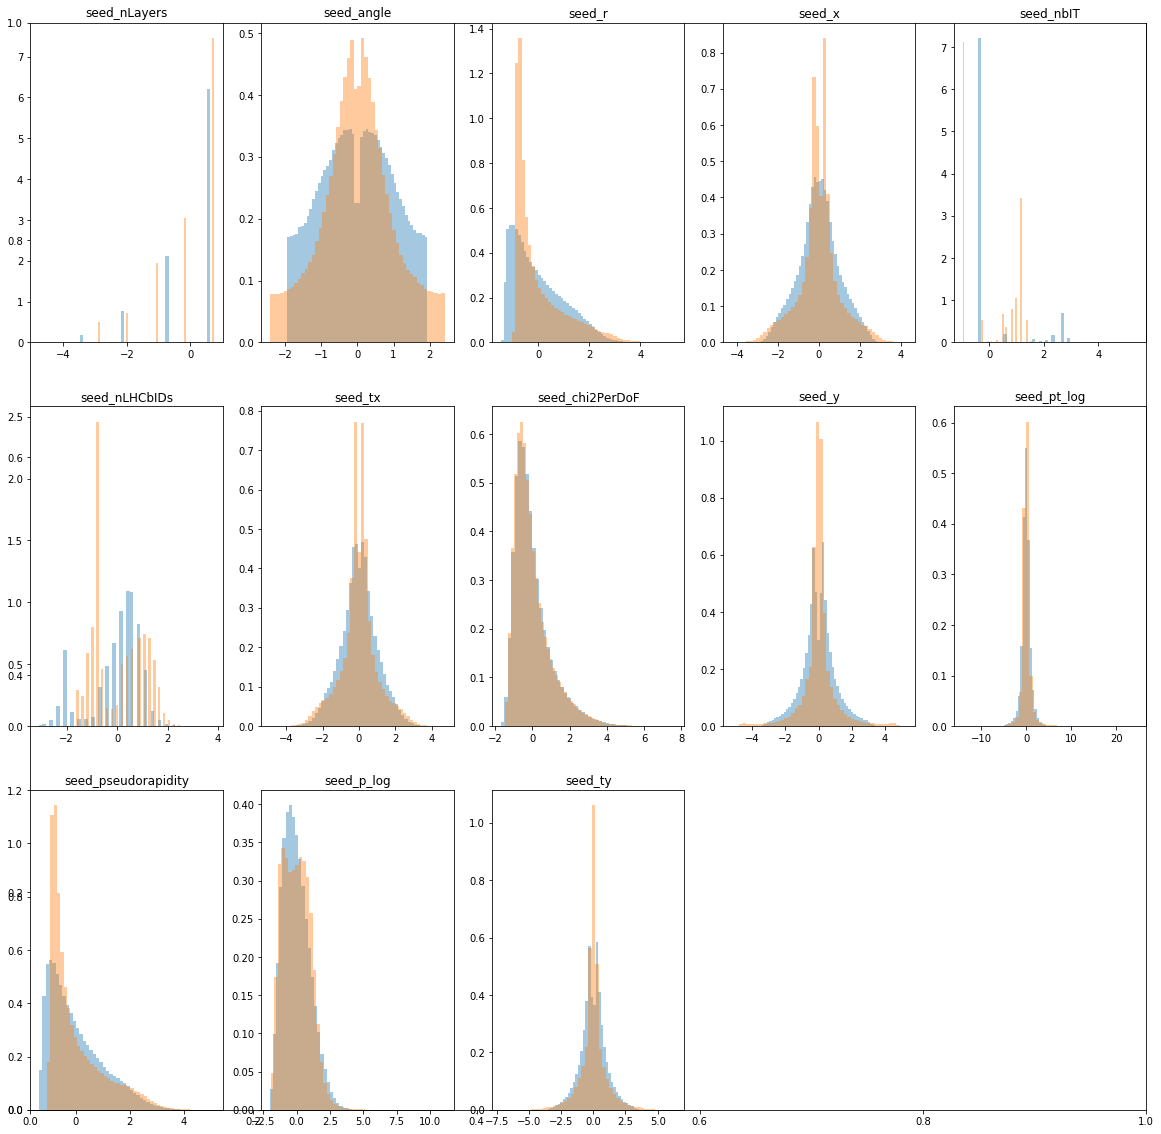

In [3]:
import matplotlib.pyplot as plt
import seaborn
import math

f, ax = plt.subplots(figsize=(20,20))
nrows = math.floor(math.sqrt(len(variable_names)))
ncols = math.ceil(len(variable_names) / nrows)

for index, variable in enumerate(variable_names):
  f.add_subplot(nrows, ncols, index + 1)
  seaborn.distplot(signal_data[variable], kde=False, norm_hist = True).set_title(variable)
  seaborn.distplot(background_data[variable], kde=False, norm_hist = True).set_title(variable)

Calculate separation for each variable and sort:

In [4]:
separation_values = []

for variable in variable_names:

  minimum = min(signal_data[variable].min(), background_data[variable].min())
  maximum = max(signal_data[variable].max(), background_data[variable].max())

  bincontent1, _ = numpy.histogram(signal_data[variable], 1000, range=[minimum,maximum])
  bincontent2, _ = numpy.histogram(background_data[variable], 1000, range=[minimum,maximum])

  separation_values.append(round(100*0.5*sum(map(abs, bincontent1 / sum(bincontent1) - bincontent2 / sum(bincontent2))), 2))

#WARNING: DON'T MODIFY THESE TWO AFTER THIS POINT
separation_values, variable_names = zip(*sorted(zip(separation_values, variable_names), key=lambda x: x[0], reverse=True))

for sep, var in zip(separation_values, variable_names):
  print([sep, var])

[100.0, 'seed_nLayers']
[100.0, 'seed_nLHCbIDs']
[99.88, 'seed_nbIT']
[31.99, 'seed_r']
[31.71, 'seed_y']
[28.41, 'seed_ty']
[21.98, 'seed_pseudorapidity']
[19.19, 'seed_x']
[19.1, 'seed_angle']
[17.6, 'seed_tx']
[16.09, 'seed_pt_log']
[8.93, 'seed_p_log']
[3.02, 'seed_chi2PerDoF']


Calculate correlation matrices, indexed by variable position in variable_names or separation_values:

In [0]:
signal_correlation_matrix = numpy.corrcoef([signal_data[var] for var in variable_names])
background_correlation_matrix = numpy.corrcoef([background_data[var] for var in variable_names])

Plot matrices:

Text(0.5, 1, 'background')

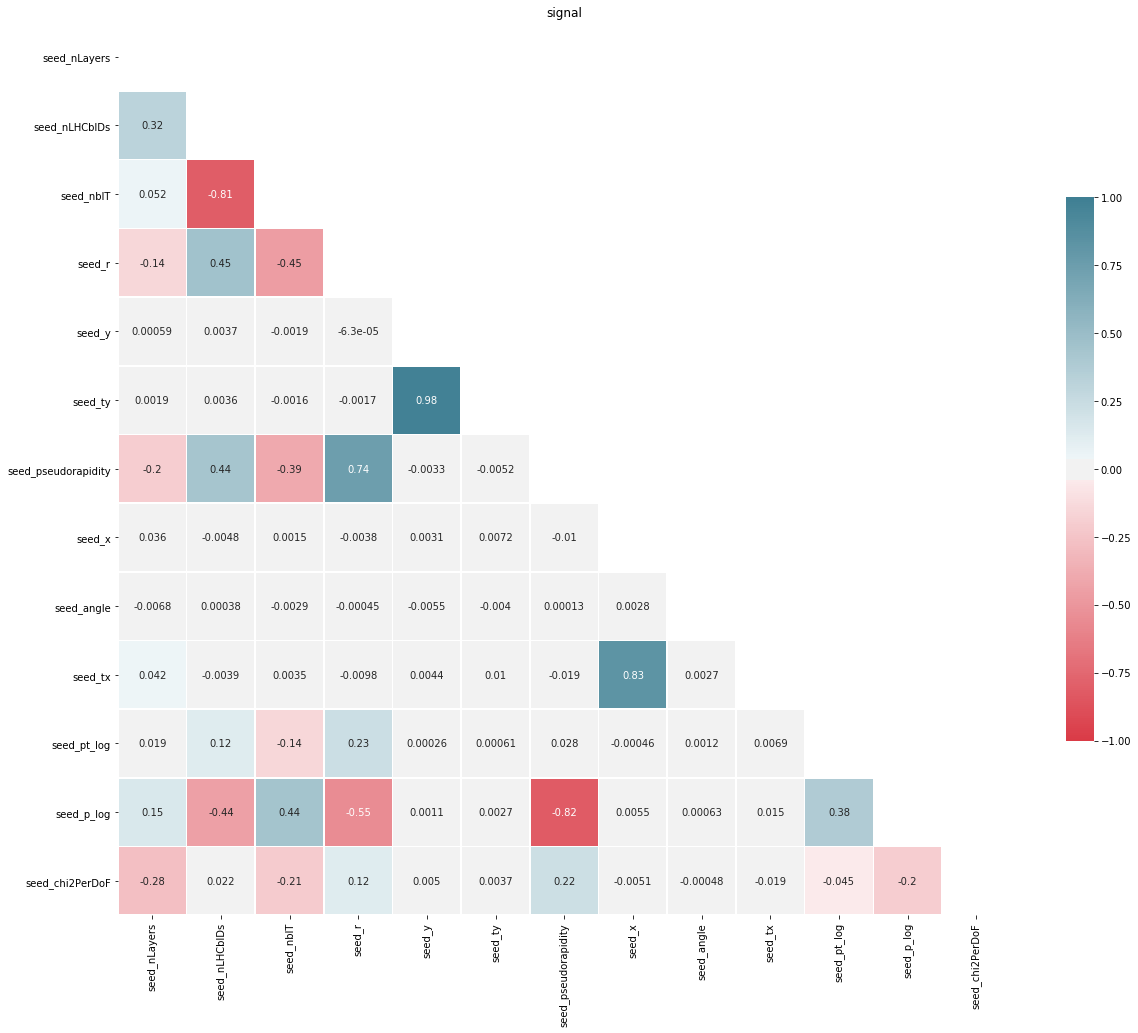

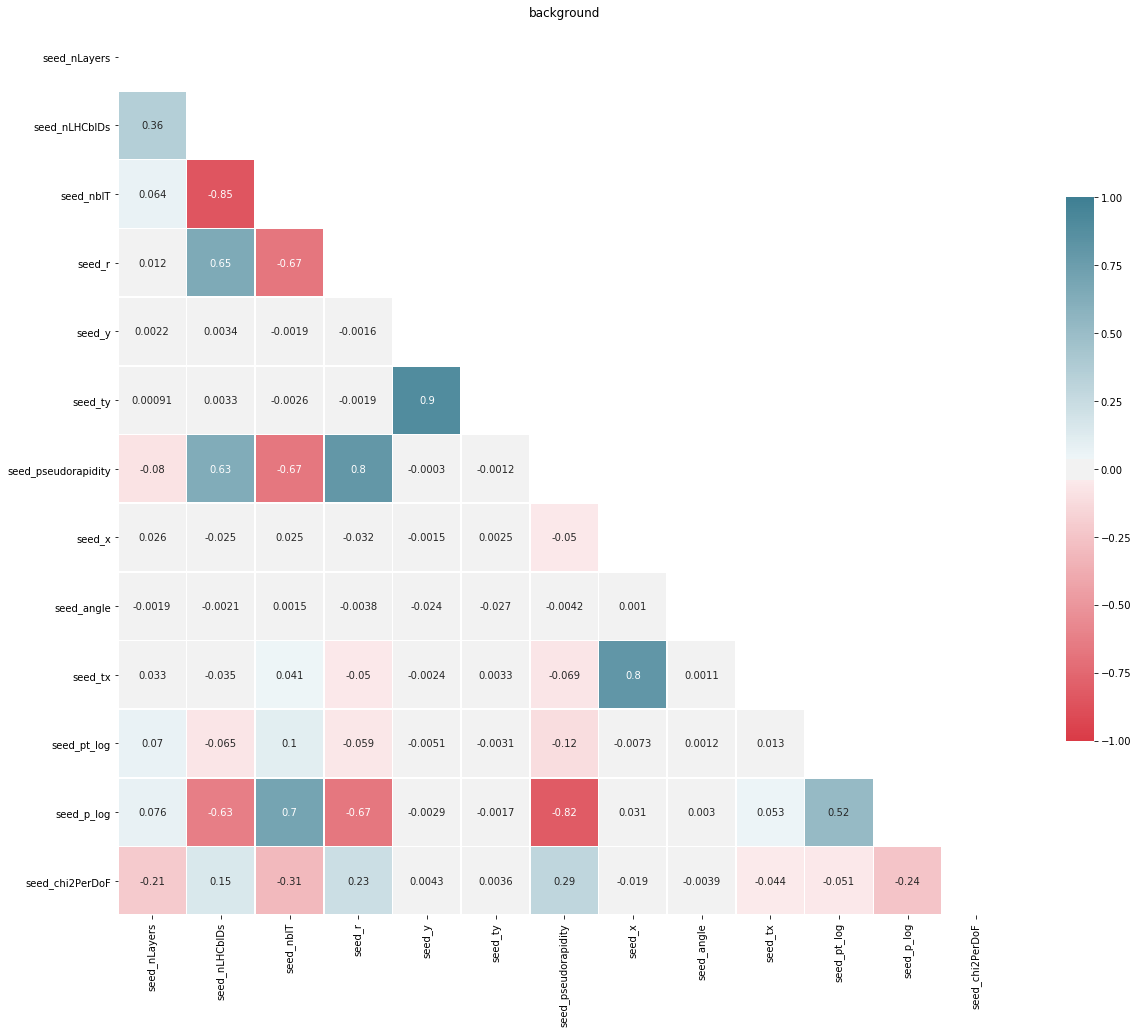

In [6]:
mask = numpy.triu(numpy.ones_like(signal_correlation_matrix, dtype=numpy.bool))
cmap = seaborn.diverging_palette(10, 220, as_cmap=True)

f, ax = plt.subplots(figsize=(20, 20))
seaborn.heatmap(signal_correlation_matrix, annot=signal_correlation_matrix, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, xticklabels = variable_names, yticklabels = variable_names).set_title('signal')

f, ax = plt.subplots(figsize=(20, 20))
seaborn.heatmap(background_correlation_matrix, annot=background_correlation_matrix, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, xticklabels = variable_names, yticklabels = variable_names).set_title('background')

Generate variable sets:

In [7]:
variable_sets = []

#add set with all variables at index 0
variable_sets.append({'pearson' : 'N/A', 'cutoff' : 'N/A', 'mask' : numpy.ones_like(variable_names, dtype=bool), 'loss' : None, 'accuracy' : None})

for pearson in pearson_coeff_thresholds:
  for cutoff in cutoff_values:

    mask = numpy.ones_like(variable_names, dtype=bool)

    for lower_sep_index in reversed(range(len(separation_values))):

      if separation_values[lower_sep_index] <= cutoff:
        mask[lower_sep_index] = 0
        continue

      for higher_sep_index in range(lower_sep_index):

        if math.fabs(signal_correlation_matrix[lower_sep_index][higher_sep_index]) >= pearson or math.fabs(background_correlation_matrix[lower_sep_index][higher_sep_index]) >= pearson: 
          mask[lower_sep_index] = 0
          break
    
    #check whether variable set already exists, if yes choose the lowest pearson and highest cutoff of the two
    duplicate = False
    for variable_set in variable_sets:
      if(numpy.all(numpy.equal(variable_set['mask'], mask))):
        variable_set['pearson'] = min(variable_set['pearson'], pearson)
        variable_set['cutoff'] = max(variable_set['cutoff'], cutoff)
        duplicate = True
        break

    if not duplicate:
      variable_sets.append({'pearson' : pearson, 'cutoff' : cutoff, 'mask' : mask, 'loss' : None, 'accuracy' : None})

print(len(variable_sets))
print(variable_sets)

5
[{'pearson': 'N/A', 'cutoff': 'N/A', 'mask': array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True]), 'loss': None, 'accuracy': None}, {'pearson': 0.5, 'cutoff': 15, 'mask': array([ True,  True, False, False,  True, False, False,  True,  True,
       False,  True, False, False]), 'loss': None, 'accuracy': None}, {'pearson': 0.5, 'cutoff': 20, 'mask': array([ True,  True, False, False,  True, False, False, False, False,
       False, False, False, False]), 'loss': None, 'accuracy': None}, {'pearson': 0.7, 'cutoff': 15, 'mask': array([ True,  True, False,  True,  True, False, False,  True,  True,
       False,  True, False, False]), 'loss': None, 'accuracy': None}, {'pearson': 0.7, 'cutoff': 20, 'mask': array([ True,  True, False,  True,  True, False, False, False, False,
       False, False, False, False]), 'loss': None, 'accuracy': None}]


Prepare data for ML:

In [8]:
import pandas

X1 = pandas.DataFrame(data=signal_data)
Y1 = pandas.DataFrame(data=numpy.ones(X1.shape[0]))

X2 = pandas.DataFrame(data=background_data)
Y2 = pandas.DataFrame(data=numpy.zeros(X2.shape[0]))

X = X1.append(X2, ignore_index=True)
Y = Y1.append(Y2, ignore_index=True)

print(X)
print(Y)

         seed_nLayers  seed_angle  ...  seed_p_log   seed_ty
0            0.618477    0.766195  ...    0.348410 -0.531145
1            0.618477    0.381837  ...   -1.215776 -0.215817
2            0.618477   -0.322396  ...   -0.883835 -0.473153
3           -2.073328   -1.089225  ...   -0.027998 -0.734420
4           -0.727425    0.112569  ...   -0.126287  0.053903
...               ...         ...  ...         ...       ...
1792763     -0.172380   -0.561237  ...   -0.420330  0.347091
1792764     -0.172380   -0.200334  ...   -0.438389  0.240612
1792765     -0.172380    2.053043  ...    0.421293  1.080958
1792766     -1.087273   -0.429294  ...   -1.834622 -0.129583
1792767     -2.002166    1.769272  ...   -1.233949  2.907711

[1792768 rows x 13 columns]
           0
0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
...      ...
1792763  0.0
1792764  0.0
1792765  0.0
1792766  0.0
1792767  0.0

[1792768 rows x 1 columns]


Test variable sets:

In [9]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

for set_number, variable_set in enumerate(variable_sets):

  print('Testing set ' + str(set_number + 1) + ' out of ' + str(len(variable_sets)))
  #setup model
  model = Sequential()
  model.add(Dense(64, activation='relu', input_dim = numpy.sum(variable_set['mask'])))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  callback = [EarlyStopping(monitor='val_loss', patience=3)]

  training_events = numpy.random.random_integers(0, X.shape[0]-1, X.shape[0]-1)

  history = model.fit(X.iloc[training_events, variable_set['mask']].values, Y.iloc[training_events].values,
                    validation_split=0.2, epochs=50, batch_size=256, callbacks=callback, verbose=1)
  
  variable_set['accuracy'] = history.history['val_acc'][-5]
  variable_set['loss'] = history.history['val_loss'][-5]

  K.clear_session()

Testing set 1 out of 5
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: This function is deprecated. Please call randint(0, 1792767 + 1) instead


Train on 1434213 samples, validate on 358554 samples
Epoch 1/50
1434213/1434213 [==============================] - 14s 10us/sample - loss: 0.0200 - acc: 0.9920 - val_loss: 5.2213e-04 - val_acc: 0.9998
Epoch 2/50
1434213/1434213 [==============================] - 14s 10us/sample - loss: 6.4812e-04 - acc: 0.9998 - val_loss: 1.1522e-04 - val_acc: 1.0000
Epoch 3/50
1434213/1434213 [==============================] - 15s 10us/sample - loss: 3.9753e-04 - acc: 0.9999 - val_loss: 3.0188e-05 - val_acc: 1.0000
Epoch 4/50
1434213/1434213 [==============================] - 14s 10us/sample - loss: 3.9093e-04 - acc: 0.9999 - val_loss: 1.0370e-04 - val_acc: 1.0000
Epoch 5/50
1434213/1434213 [==============================] - 15s 10us/sample - loss: 2.3171e-04 - acc: 0.9999 - val_loss: 4.9162e-05 - val_acc: 1.0000
Epoch 6/50
1434213/1434213 [==============================] - 15s 10us/sample - loss: 2.5612e-04 - acc: 0.9999 - val_loss: 1.2708e-05 - val_acc: 1.0000
Epoch 7/50
1434213/1434213 [===========

Show results:

In [0]:
variable_sets.sort(key=lambda x: x['accuracy'], reverse=True)

labels = []
accuracies = []
losses = []
pearson = []
cutoff = []
number_of_variables = []

for variable_set in variable_sets:
  labels.append(str(variable_set['pearson']) + ',' + str(variable_set['cutoff']) + ',' + str(numpy.sum(variable_set['mask'])))
  accuracies.append(variable_set['accuracy'])
  losses.append(variable_set['loss'])
  if variable_set['pearson'] == 'N/A':
    pearson.append(1)
    cutoff.append(0)
  else:    
    pearson.append(variable_set['pearson'])
    cutoff.append(variable_set['cutoff'])
  number_of_variables.append(numpy.sum(variable_set['mask']))

Text(0.5, 1.0, 'accuracy')

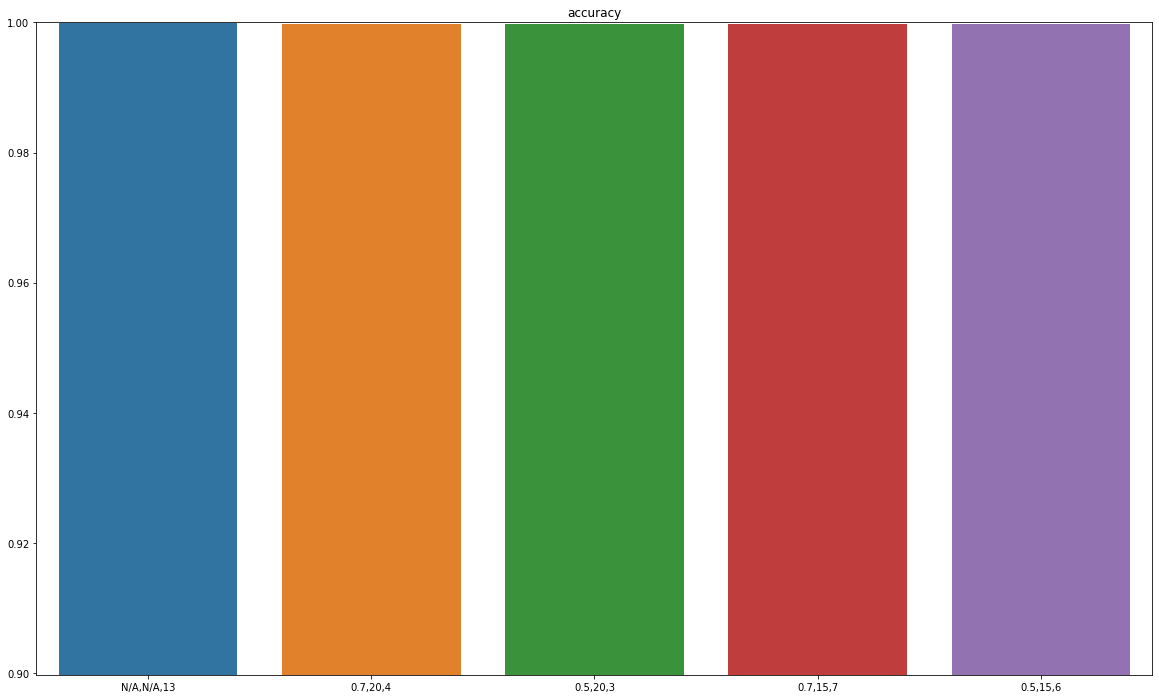

In [34]:
f, ax = plt.subplots(figsize=(20,12))
ax.set_ylim(bottom = max(min(accuracies) - 0.1, 0), top = min(max(accuracies) + 0.1, 1))
seaborn.barplot(x=labels, y=accuracies).set_title('accuracy')

Text(0.5, 1.0, 'loss')

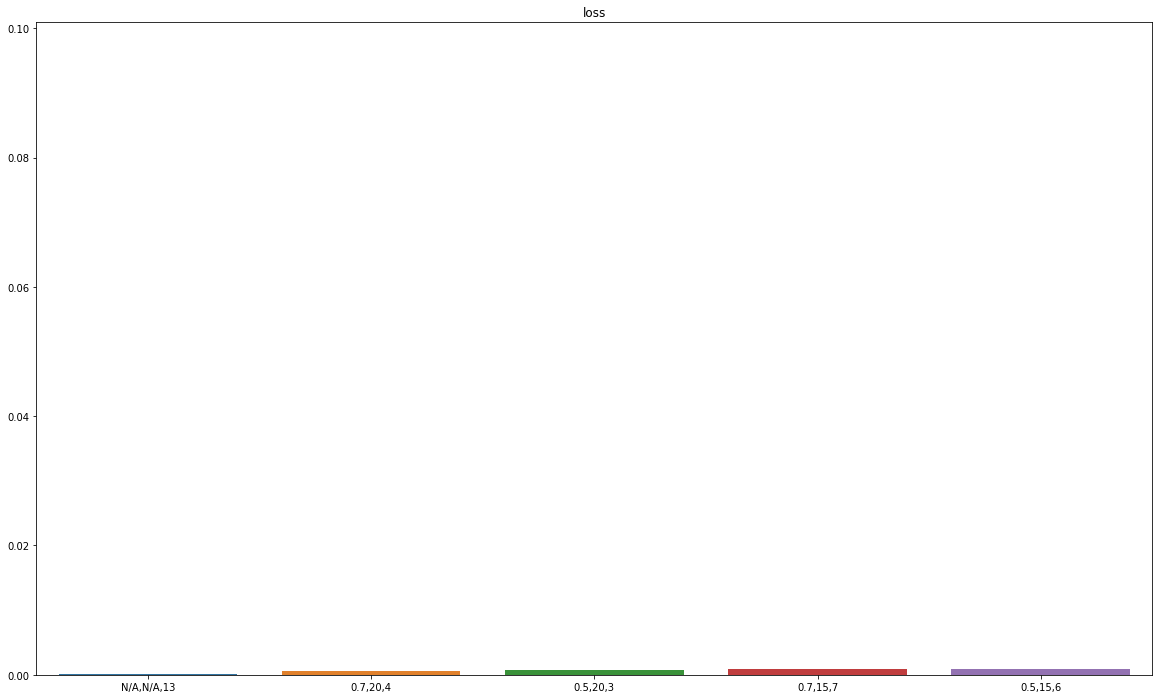

In [35]:
f, ax = plt.subplots(figsize=(20,12))
ax.set_ylim(bottom = max(min(losses) - 0.1, 0), top = min(max(losses) + 0.1, 1))
seaborn.barplot(x=labels, y=losses).set_title('loss')

Text(0.5, 1.0, 'pearson')

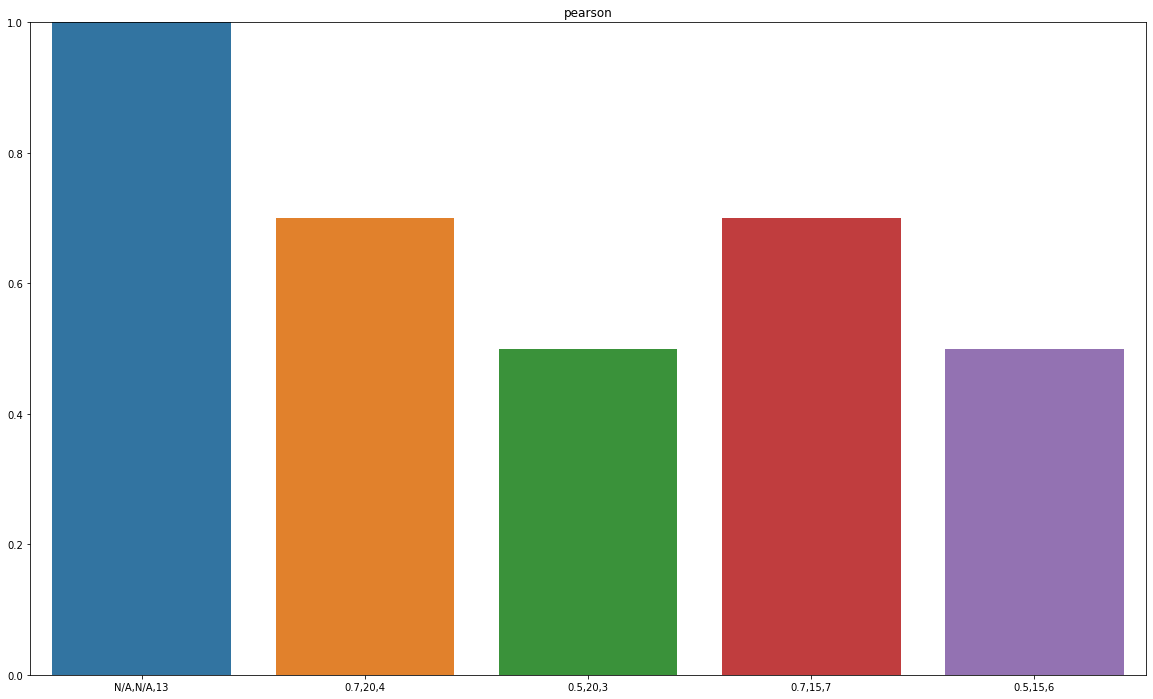

In [36]:
f, ax = plt.subplots(figsize=(20,12))
ax.set_ylim(bottom = max(min(pearson) - 5, 0), top = 1)
seaborn.barplot(x=labels, y=pearson).set_title('pearson')

Text(0.5, 1.0, 'cutoff')

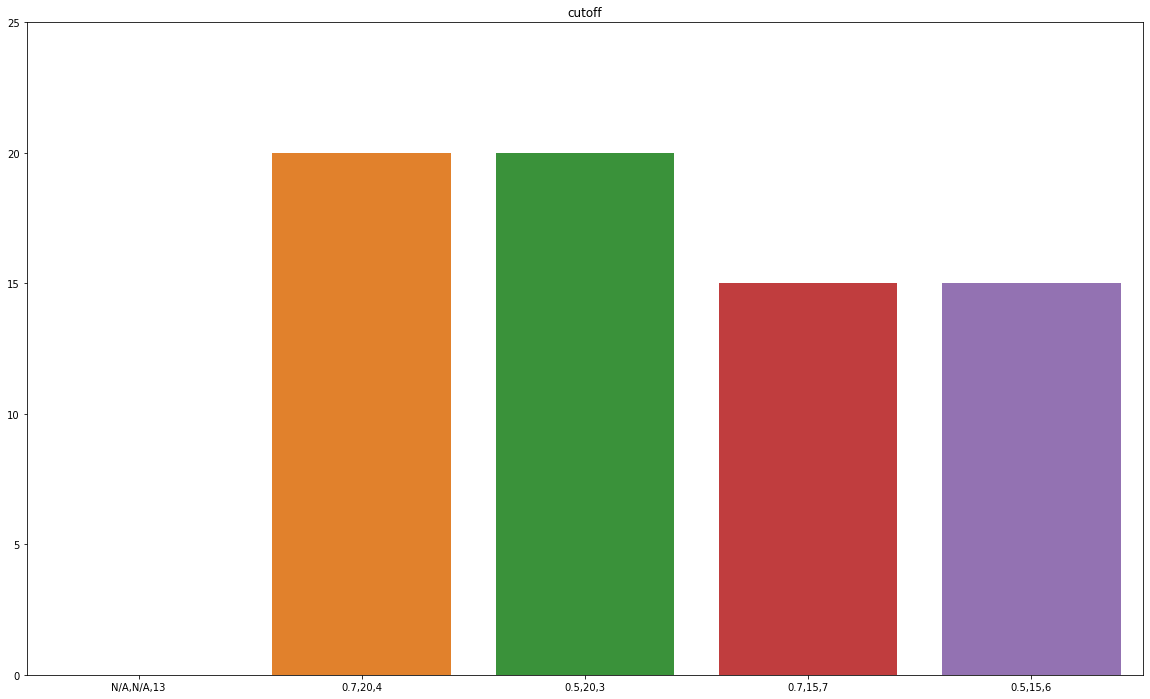

In [37]:
f, ax = plt.subplots(figsize=(20,12))
ax.set_ylim(bottom = max(min(cutoff) - 5, 0), top = max(cutoff) + 5)
seaborn.barplot(x=labels, y=cutoff).set_title('cutoff')

Text(0.5, 1.0, 'number of variables')

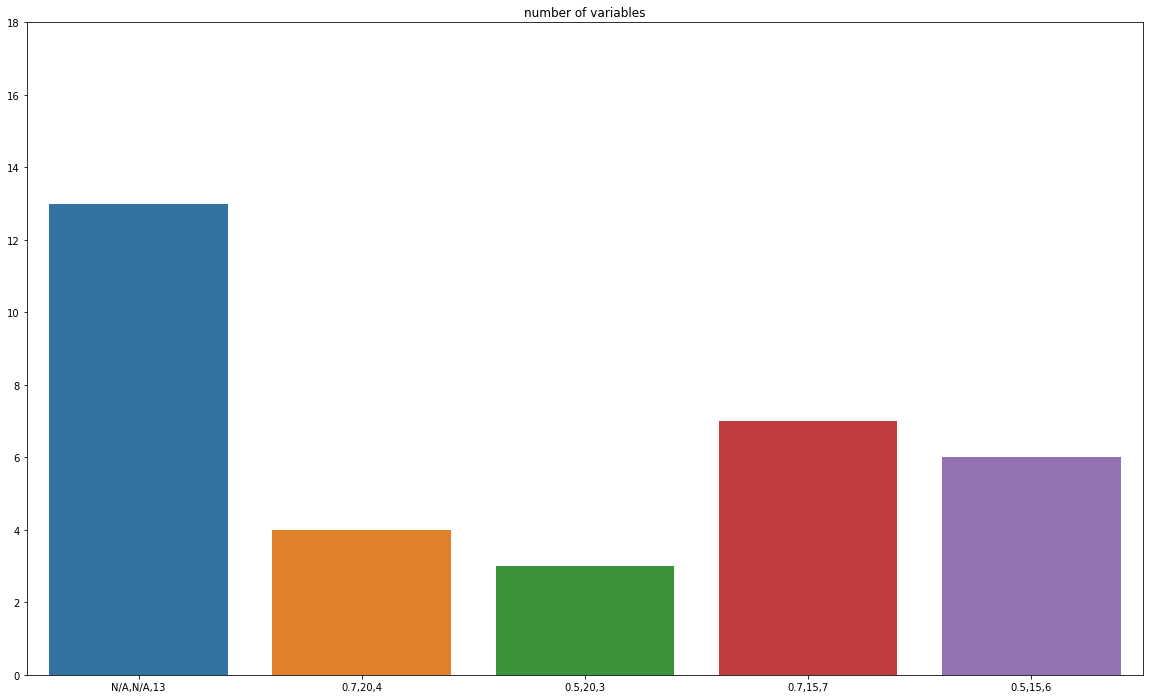

In [38]:
f, ax = plt.subplots(figsize=(20,12))
ax.set_ylim(bottom = max(min(number_of_variables) - 5, 0), top = max(number_of_variables) + 5)
seaborn.barplot(x=labels, y=number_of_variables).set_title('number of variables')

In [39]:
for variable_set in variable_sets:

  print(['accuracy', variable_set['accuracy']])
  print(['loss', variable_set['loss']])
  print(['pearson', variable_set['pearson']])
  print(['cutoff', variable_set['cutoff']])
  print(['number of variables', numpy.sum(variable_set['mask'])])
  print(['variables:'])
  for index, mask_value in enumerate(variable_set['mask']):
    if mask_value:
      print([separation_values[index], variable_names[index]])

  print('')
  print('')

['accuracy', 0.9999777]
['loss', 4.9161680939748875e-05]
['pearson', 'N/A']
['cutoff', 'N/A']
['number of variables', 13]
['variables:']
[100.0, 'seed_nLayers']
[100.0, 'seed_nLHCbIDs']
[99.88, 'seed_nbIT']
[31.99, 'seed_r']
[31.71, 'seed_y']
[28.41, 'seed_ty']
[21.98, 'seed_pseudorapidity']
[19.19, 'seed_x']
[19.1, 'seed_angle']
[17.6, 'seed_tx']
[16.09, 'seed_pt_log']
[8.93, 'seed_p_log']
[3.02, 'seed_chi2PerDoF']


['accuracy', 0.9998215]
['loss', 0.0006146038354518283]
['pearson', 0.7]
['cutoff', 20]
['number of variables', 4]
['variables:']
[100.0, 'seed_nLayers']
[100.0, 'seed_nLHCbIDs']
[31.99, 'seed_r']
[31.71, 'seed_y']


['accuracy', 0.99976575]
['loss', 0.0007076394245418496]
['pearson', 0.5]
['cutoff', 20]
['number of variables', 3]
['variables:']
[100.0, 'seed_nLayers']
[100.0, 'seed_nLHCbIDs']
[31.71, 'seed_y']


['accuracy', 0.99973506]
['loss', 0.0008936864089013024]
['pearson', 0.7]
['cutoff', 15]
['number of variables', 7]
['variables:']
[100.0, 'seed_nLayers']
[100.0